# Майнор по Анализу Данных, Группа ИАД-4
## 07/09/2017 Метод Опорных Векторов

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')

## Вспоминаем про линейные модели

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png' width=400></center>

Уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = w_0 + \langle w, x \rangle = w_0 +  w^\top x $$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'} = +1$
* Если $g(x^*) < 0$, то $y^* = \text{'белый'} = -1$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{|g(x)|}{||w||}$ - расстояние от точки $x$ до гиперплоскости, степень "уверенности" в классификациий
* Величину $M = y(\langle w, x \rangle + w_0) = y \cdot g(x)$ называют **отступом**(margin)

Если для какого-то объекта $x_i$ его отступ $M_i \geq 0$, то его классификация выполнена успешно.

$$L(w) = \sum_i [y^{(i)} (\langle w, x^{(i)} \rangle + w_0) < 0] \rightarrow \min_{w, w_0}$$
<center><img src='http://jaquesgrobler.github.io/Online-Scikit-Learn-stat-tut/_images/plot_sgd_loss_functions_11.png' width=600></center>

##  Линейноразделимый случай с двумя классами
* Заметим что $g(x) = w_0 + \langle w, x \rangle$ и $g'(x) = c \cdot (w_0 + \langle w, x \rangle)$, $\forall c>0$ задают одну и ту же гиперплоскость
* Подберем $c$ таким образом, чтобы $\min\limits_i M_i = \min\limits_i y^{(i)} \cdot g(x^{(i)}) = 1$
* Объекты $x^{(i)}$ для которых $M^*_i = 1$ будем называть опорными
<center><img src='./images/margin.png'></center>
* Таким образом выполняются следующие неравенства:
    * $w_0 + \langle w, x^{(i)} \rangle \geq 1$, если $y^{(i)} = + 1$
    * $w_0 + \langle w, x^{(i)} \rangle \leq - 1$, если $y^{(i)} = - 1$

* Разделяющая полоса:  $ -1 \leq w_0 + \langle w, x \rangle \leq +1$
* Ширина разделяющей полосы:
 $$\langle (x^{+} -  x^{-}) , \frac{w}{||w||}\rangle = \frac{\langle w, x^{+} \rangle - \langle w, x^{-} \rangle }{||w||} = \frac{2}{||w||}  \rightarrow \max$$
 
 
* Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2  \rightarrow \min  \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 \quad i=1\dots n
\end{cases}
$$

In [10]:
from sklearn.datasets.samples_generator import make_classification

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)

(-3, 4)

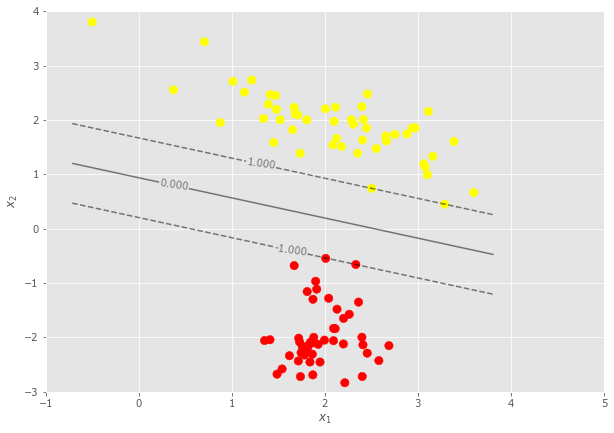

In [26]:
class_sep = 2

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                           n_redundant=0, n_clusters_per_class=1, random_state=31)

lin_svm = SVC(kernel='linear', C=100).fit(X, y)

# Plotting the splitting hyperplane and support vectors
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(lin_svm)
plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(-1, 5)
plt.ylim(-3, 4)

## Неразделимый случай 

Будем допускать пропуск объектов за разделительную линию
* Вместо условия $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1$
* Будет условие $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i, \quad \xi_i \geq 0$

<center><img src='./images/slack.png'></center>

А целевой функционал заменим на 

$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$

Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi} \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i \quad i=1\dots n \\
   \xi_i \geq 0 \quad i=1\dots n
\end{cases}
$$


In [27]:
## Demo with soft margin

## Ядра и спрямляющие пространства

<center><img src='images/interstellar.jpg' width='600'></center>

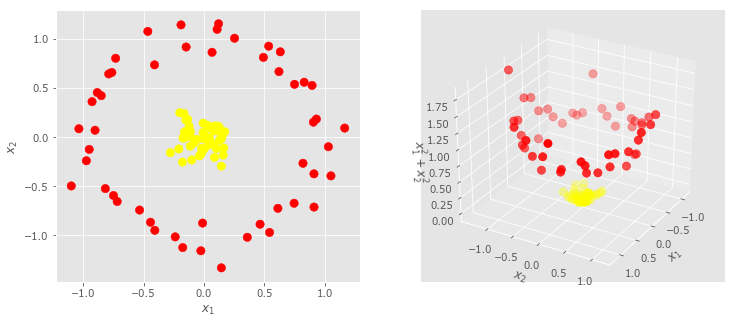

In [28]:
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits import mplot3d

X, y = make_circles(n_samples=100, factor=0.1, 
                    noise=0.1, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)

ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

r = X[:, 0] ** 2 + X[:, 1] ** 2

ax = fig.add_subplot(1, 2, 2)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_1^2 + x_2^2$')

* $\psi: X \rightarrow H$
* $H$ - пространство большей размерности, в котором классы становятся линейноразделимыми называется **спрямляющим**.
* Разделяющся гиперплоскость в таком пространстве будет линейной, но при проекции на исходное пространство $X$ - нет

Представим, что мы как-то перешли в спрямляющее пространство и хотим строить SVM там? Что изменится в задаче оптимизации?

Наиболее популярны следующие ядра:

1. Линейное (linear): $$\langle x, y\rangle$$
2. Полиномиальное (polynomial): $$(\gamma \langle x, y\rangle + с)^d,$$ 
3. Radial basis function kernel (rbf): $$e^{(-\gamma  \cdot \|x - y\|^2)},$$ 
4. Sigmoid: $$\tanh(\gamma \langle x,y \rangle + r)$$ 

In [ ]:
from IPython.display import YouTubeVideo

In [ ]:
YouTubeVideo('3liCbRZPrZA', width=640, height=480)

In [29]:
## Kernels Demo

## Метод опорных векторов для регрессии?

# Практика

Загрузите текстовые данные [отсюда](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/). Архив должен содержать 3 файла с положительными и отрицательными отзывами с ресурсов
* imdb.com
* amazon.com
* yelp.com

Формат файла следующий:
<отзыв>\t<метка>\n


### Задача
1. Загрузите тексты и метки классов в разные переменные
2. Выберите меру качества классификации
3. Обучите линейный SVM (без подбора гиперпараметров). Тексты представляются в виде мешка слов
4. Выведите наиболее значимые слова из текста
5. С помощью кросс-валидации и валидационных кривых исследуйте, как различные комбинции параметров влияют на качество